In [11]:
from memory.unsafe import DTypePointer
from memory import memset_zero
from memory.buffer import Buffer
from math import sin, atan, cos, sqrt

#alias sixth =1.0/6.0


struct Field[DT: DType]:
    var data: DTypePointer[DT]
    var gx: Int
    var gy: Int
    var gz: Int
    var dsize: Int
    var eigenval: SIMD[DT,1]
    var bcurr: Buffer[0,DT]
    var bnext: Buffer[0,DT]
    #alias pi = 4.0*atan[DT,1](1.0)
    
    fn __init__(inout self, gx: Int, gy: Int, gz: Int):
        self.dsize = gx * gy * gz
        self.data = DTypePointer[DT].alloc(2 * self.dsize)
        #memset_zero(self.data, self.dsize)
        self.gx = gx
        self.gy = gy
        self.gz = gz
        self.bcurr = Buffer[0,DT](self.data, self.dsize)
        self.bnext = Buffer[0,DT](self.data +self.dsize,self.dsize )
        self.eigenval = 0.0

    fn __copyinit__(inout self, other: Self):
        self.gx = other.gx
        self.gy = other.gy
        self.gz = other.gz
        self.eigenval = other.eigenval
        self.data = DTypePointer[DT].alloc(2*other.dsize)
        self.dsize = other.dsize
        self.bcurr = Buffer[0,DT](self.data, self.dsize)
        self.bnext = Buffer[0,DT](self.data +self.dsize,self.dsize )
        let sd = self.bcurr #Buffer[0,DT](self.data, self.dsize)
        let od = other.bcurr #Buffer[0,DT](other.data, other.dsize)
        for i in range(0,self.dsize - self.dsize % VW,VW):
            sd.simd_store[VW](i, od.simd_load[VW](i))
        for i in range(self.dsize - self.dsize % VW, self.dsize):
            sd[i] = od[i]

    fn __add__[VW:Int](self, rhs: Field[DT]) raises -> Field[DT]:
        # test if the fields have the same sizes
        if self.gx != rhs.gx or self.gy != rhs.gy or self.gz != rhs.gz :
            raise ("cannot add fields with different grid sizes")
        let result = Field[DT](self.gx, self.gy, self.gz)
        let p : Int
        let igx = self.gx-2  # inner grid size in x dir
        let vwgx = igx - igx%VW # length made of an integer number of vector widths
        for k in range(1,self.gz-1):
            for j in range(1,self.gy-1):
                for i in range (1,vwgx+1,VW):
                    p = k * (self.gx) * (self.gy) + j * (self.gx) + i
                    result.data.simd_store[VW](p, self.data.simd_load[VW](p) + rhs.data.simd_load[VW](p))
                for i in range (vwgx+1, self.gx-1):
                    p = k * (self.gx) * (self.gy) + j * (self.gx) + i
                    result.data.simd_store[1](p, self.data.simd_load[1](p) + rhs.data.simd_load[1](p))
        return result

    #fn __del__(owned self):
    #    self.data.free()
    #    print("done del")
        
    fn zero(inout self):
        memset_zero[DT](self.data, self.dsize)

    @always_inline
    fn __getitem__(self, x: Int, y: Int, z: Int) -> SIMD[DT,1]:
        let p = z * (self.gx) * (self.gy) + y * (self.gx) + x 
        return self.data.load(p)

    #@always_inline
    #fn load[nelts:Int=VW](self, x: Int, y: Int, z: Int) -> SIMD[DT,nelts]:
    #    return self.data.simd_load[nelts](z * (self.gx+2) * (self.gy+2) + y * (self.gx+2) + x)

    @always_inline
    fn __setitem__(self, x: Int, y: Int, z: Int, val: SIMD[DT,1]):
        return self.data.store(z * (self.gx) * (self.gy) + y * (self.gx) + x, val)

    #@always_inline
    #fn store[nelts:Int=VW](self, x: Int, y: Int, z: Int, val: SIMD[DT, nelts]):
    #    self.data.simd_store(z * (self.gx+2) * (self.gy+2) + y * (self.gx+2) + x, val)

    # boundaries: all 0 for a start
    fn set_bc(inout self, iis: Int, ie:Int, js:Int, je:Int, ks:Int, ke:Int):
        for k in range(ks,ke):
            for j in range(js,je):
                for i in range(iis,ie):
                    let p = k * self.gy * self.gx + j * self.gx + i 
                    self.bcurr[p] = 0.0 
                    self.bnext[p] = 0.0

    fn initialize(inout self):
        # inner points
        let pi = SIMD[DT,1](4)*atan(SIMD[DT,1](1))  # overkill ?
        for k in range(1,self.gz-1):
            for j in range(1,self.gy-1):
                for i in range(1,self.gx-1):
                    #self[i,j,k] = sin[1, DType.f32](1.0*(i+j+k))
                    self.bcurr[self.bidx(i,j,k)] = sin(pi*i/(self.gx-1)) \
                    * sin(pi*j/(self.gy-1)) \
                    * sin(pi*k/(self.gz-1))
        # bc north
        self.set_bc(0, 1, 1, self.gy-1, 1, self.gz-1)
        # bc south
        self.set_bc(self.gx-1, self.gx, 1, self.gy-1, 1, self.gz-1)
        # bc west
        self.set_bc(1, self.gx-1, 0, 1, 1, self.gz-1)
        # bc east
        self.set_bc(1, self.gx-1, self.gy-1, self.gy, 1, self.gz-1)
        # bc botttom
        self.set_bc(1, self.gx-1, 1, self.gy-1, 0, 1)
        # bc top
        self.set_bc(1, self.gx-1, 1, self.gy-1, self.gz-1, self.gz)

        let kx = 1.0
        let ky = 1.0
        let kz = 1.0
        self.eigenval = (cos(pi*kx/(self.gx-1)) + cos(pi*ky/(self.gy-1)) + cos(pi*kz/(self.gz-1)))/3.0

    fn norm2 (self) -> SIMD[DT,1] :
        var s : SIMD[DT, 1] = 0.0
        for k in range(1,self.gz-1):
            for j in range(1,self.gy-1):
                for i in range(1,self.gx-1):
                   # self[i,j,k] = sin[1, DType.f32](1.0*pi)
                   s = s + self.bcurr[self.bidx(i,j,k)] ** 2
        return s
    
    fn bidx(self, i:Int, j:Int, k:Int) -> Int:
        return k*self.gy*self.gx + j*self.gx +i

    fn iterate(inout self, niter: Int, test_it: Bool = False):
        let sixth = 1.0/6.0
        var norm_start = SIMD[DT,1](0.0)
        if test_it:
            norm_start = self.norm2()
        for iter in range(niter):
            for k in range(1,self.gz-1):
                for j in range(1,self.gy-1):
                    for i in range(1,self.gx-1):
                        self.bnext[self.bidx(i,j,k)]= sixth * ( 
                            self.bcurr[self.bidx(i-1,j  ,k  )] + self.bcurr[self.bidx(i+1,j  ,k  )] +
                            self.bcurr[self.bidx(i  ,j-1,k  )] + self.bcurr[self.bidx(i  ,j+1,k  )] +
                            self.bcurr[self.bidx(i  ,j  ,k-1)] + self.bcurr[self.bidx(i  ,j  ,k+1)])
            let aux = self.bcurr
            self.bcurr = self.bnext
            self.bnext = aux
        
        if test_it :
            print ("iter test: ",  sqrt(self.norm2()/norm_start) - self.eigenval**niter)


    fn iterate_simd[VW:Int](inout self, niter: Int, test_it: Bool = False):
        let sixth = 1.0/6.0
        var norm_start = SIMD[DT,1](0.0)
        if test_it:
            norm_start = self.norm2()

        let igx = self.gx-2
        let vwgx = igx - igx%VW 
        for iter in range(niter):
            for k in range(1,self.gz-1):
                for j in range(1,self.gy-1):
                    for i in range(1,1+vwgx,VW):
                        self.bnext.simd_store(self.bidx(i,j,k), sixth * (
                            self.bcurr.simd_load[VW](self.bidx(i-1,j  ,k  )) + self.bcurr.simd_load[VW](self.bidx(i+1,j  ,k  )) +
                            self.bcurr.simd_load[VW](self.bidx(i  ,j-1,k  )) + self.bcurr.simd_load[VW](self.bidx(i  ,j+1,k  )) +
                            self.bcurr.simd_load[VW](self.bidx(i  ,j  ,k-1)) + self.bcurr.simd_load[VW](self.bidx(i  ,j  ,k+1))))
                    for i in range (vwgx+1, self.gx-1):
                        self.bnext[self.bidx(i,j,k)]= sixth * ( 
                            self.bcurr[self.bidx(i-1,j  ,k  )] + self.bcurr[self.bidx(i+1,j  ,k  )] +
                            self.bcurr[self.bidx(i  ,j-1,k  )] + self.bcurr[self.bidx(i  ,j+1,k  )] +
                            self.bcurr[self.bidx(i  ,j  ,k-1)] + self.bcurr[self.bidx(i  ,j  ,k+1)])

            let aux = self.bcurr
            self.bcurr = self.bnext
            self.bnext = aux
        
        if test_it :
            print ("iter test: ",  sqrt(self.norm2()/norm_start) - self.eigenval**niter)






npoints  65
N   time  Swaps  LUPS
30 0.00092232574867608119 13596 0.071402105052938827 0 30.0 0.07140210505293883
35 0.0016177745128318584 6780 0.066641549328948543 1 35.0 0.06664154932894854
40 0.0025999075142478464 4527 0.063316098398839935 2 40.0 0.06331609839883993
45 0.0005361136694214876 6171 0.44490751421687219 3 45.0 0.4449075142168722
50 0.00028757760687245194 5151 1.1536920541492344 4 50.0 1.1536920541492344
55 0.000204361358598207 3681 2.1854963338647457 5 55.0 2.1854963338647457
60 0.00027962475413450936 2721 2.0932910672079936 6 60.0 2.0932910672079936
65 0.00037120538848920862 2085 2.0208246519616662 7 65.0 2.020824651961666
70 0.00048191635264054517 1761 1.9573853321877033 8 70.0 1.9573853321877033
75 0.00055584934947368423 1425 2.0995814803148423 9 75.0 2.0995814803148423
80 0.00072883695956873313 1113 1.9533257490706903 10 80.0 1.9533257490706903
85 0.00080521806070287547 939 2.1303061663851155 11 85.0 2.1303061663851155
90 0.0009640005280898877 801 2.120762323700065 1

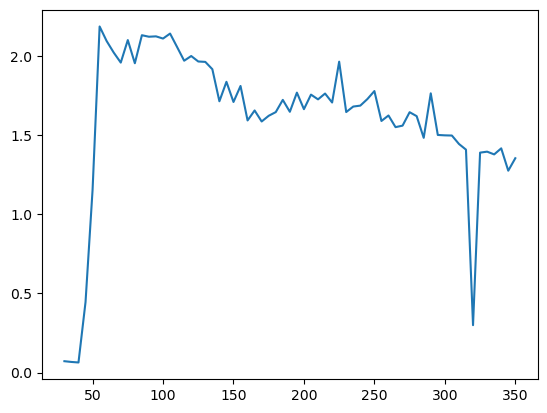

In [14]:
import benchmark
from python import Python

alias VW = 4 # simd vector width (sys function not working)

fn run(gmin:Int, gmax:Int, gstep:Int, nswaps:Int=3) raises:
    let np = Python.import_module("numpy")
    let npoints = (gmax-gmin)//gstep +1
    let pdatx = np.zeros(npoints)
    let pdaty = np.zeros(npoints)
    print("npoints ", npoints)
    print("N   time  Swaps  LUPS")
    var idx = 0
    for n in range(gmin,gmax,gstep):
        #print("min max n", gmin, gmax, n, idx)
        var phi=Field[DType.float32](n,n,n)
        phi.initialize()
        @parameter
        fn test_fn():
            phi.iterate_simd[VW](nswaps)

        let rep = benchmark.run[test_fn](max_runtime_secs=2, min_runtime_secs=0.1)
        phi.data.free()
        let t = rep.mean()
        let s = (n-2)**3/(t/nswaps)/1e9
        _ = pdatx.itemset(idx, n)
        _ = pdaty.itemset(idx, s)
        print(n, t, rep.iters() * nswaps, s, idx, pdatx[idx], pdaty[idx])
        idx += 1
    #report.print()

    let pyplt = Python.import_module("matplotlib.pyplot")
    _ = pyplt.plot(pdatx,pdaty)
    _ = pyplt.show()
    


run(30,351,5)

In [21]:
from sys.info import is_x86

from TargetInfo import simdwidthof, simdbitwidth
#    alignof,
#    bitwidthof,
#    simdwidthof,
#    simdbitwidth,
#    simd_byte_width,
#    sizeof
#)


from DType import DType

fn t1():
    print("hello")
    print(simdbitwidth()) #[DType.float32]())

t1()

hello


In [7]:
#from python import Python
let pi = 4.0*atan[DType.float32,1](1.0)
let n=9
alias w=4
var a = Field[DType.float32,w](n,3,3)
var b = Field[DType.float32,w](n,3,3)
#var c = Field[DType.float32,w](n,1,1)



a.initialize()
print("a norm", a.norm2())
b.initialize()
print("b norm",b.norm2())
for i in range(0,n):
    print(i, a[i,1,1], b[i,1,1], sin((pi*i)/(n-1)))
let c : Field[DType.float32,w] = a + b
print(c.norm2()/a.norm2())
#c.zero()
#for i in range(1,n+1):
#    print(i, c[i,1,1])



a norm 3.9999997615814209
b norm 3.9999997615814209
0 0.0 0.0 0.0
1 0.38268345594406128 0.38268345594406128 0.38268345594406128
2 0.70710676908493042 0.70710676908493042 0.70710676908493042
3 0.92387950420379639 0.92387950420379639 0.92387950420379639
4 1.0 1.0 1.0
5 0.92387950420379639 0.92387950420379639 0.92387950420379639
6 0.70710676908493042 0.70710676908493042 0.70710676908493042
7 0.38268327713012695 0.38268327713012695 0.38268327713012695
8 0.0 0.0 -8.7422776573475858e-08
done del
0.0064284889958798885


In [9]:
from memory.buffer import Buffer
from memory.unsafe import DTypePointer

alias VW = 4 # simd vector width
# var p : DTypePointer[DType.float64]
# var pb : Buffer[0,DType.float64] 

struct S1[T: DType]:
    var p: DTypePointer[T]
    var b1 : Buffer[0,T]
    var b2 : Buffer[0,T]

    fn __init__(inout self, n: Int):
        self.p = DTypePointer[T].alloc(n)
        self.b1 = Buffer[0,T](self.p, n//2)
        self.b2 = Buffer[0,T](self.p+n//2, n//2)

    fn swap(inout self):
        #let a = Buffer[0,T]
        let a=self.b1
        self.b1 = self.b2
        self.b2 = a

    fn update(inout self, val:SIMD[T,VW]):
        self.b1.simd_store(0,val)
        
    
var s=S1[DType.float64](8)
var a: SIMD[DType.float64, 4]
a = 0.1
s.update(a)

print(s.b1[0],s.b1[3],s.b1[4])

#var a: SIMD[DType.float64, 4]
#var b: SIMD[DType.float64, 4]
#var c: SIMD[DType.float64, 4]

#p = DTypePointer[DType.float64].alloc(4)

#var bp1 : Buffer[0,DType.float64]  #(p+2,2)
#var bp2 : Buffer[0,DType.float64]

#for i in range(4):
#    p.store(i,i)

#pb1 = p

#a = 1.0
#b=3.33
#c=a+b
#print(a,b,c)
#bp1 = Buffer[0,DType.float64](p,4)
#bp2 = bp1
#print(bp1[0], bp1[1]) #, bp2[1])

0.10000000000000001 0.10000000000000001 6.9074583717847483e-310


In [35]:
from memory.buffer import Buffer
from memory.unsafe import DTypePointer

# var p : DTypePointer[DType.float64]
# var pb : Buffer[0,DType.float64] 

struct S1[T: DType]:
    var p: DTypePointer[T]
    var b1 : Buffer[0,T]
    var b2 : Buffer[0,T]

    fn __init__(inout self, n: Int):
        self.p = DTypePointer[T].alloc(n)
        self.b1 = Buffer[0,T](self.p, n//2)
        self.b2 = Buffer[0,T](self.p+n//2, n//2)

    fn swap(inout self):
        #let a = Buffer[0,T]
        let a=self.b1
        self.b1 = self.b2
        self.b2 = a

var s = S1[DType.int32](8)
for i in range(4):
    s.b1[i]=i
    s.b2[i]=i+10
print(s.b1.simd_load[4](0))
print(s.b2.simd_load[4](0))
s.swap()
print(s.b1.simd_load[4](0))
print(s.b2.simd_load[4](0))
print(s.p.simd_load[8](0))


[0, 1, 2, 3]
[10, 11, 12, 13]
[10, 11, 12, 13]
[0, 1, 2, 3]
[0, 1, 2, 3, 10, 11, 12, 13]


In [22]:
from python import Python

fn plt() raises:
    let np = Python.import_module("numpy")
    let a1 = np.array([1,2,3,4,5])
    var a2 = np.arange(5)

    #_ = a2.itemset(1,20)
    #print(a2[2])
    #print(array)
    
    let pyplt = Python.import_module("matplotlib.pyplot")
    _ = pyplt.plot(a1, a2)
    _ = pyplt.show()



#plt()

    var a2 = np.arange(5)
    ^



In [18]:
print(350**3*8/2**20)


327.11029052734375
